In [14]:
!wget https://sherlock-holm.es/stories/plain-text/advs.txt -O sherlock_holmes_stories.txt


--2024-04-05 00:46:53--  https://sherlock-holm.es/stories/plain-text/advs.txt
Resolving sherlock-holm.es (sherlock-holm.es)... 157.90.249.21, 2a01:4f8:1c17:5725::1
Connecting to sherlock-holm.es (sherlock-holm.es)|157.90.249.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610921 (597K) [text/plain]
Saving to: ‘sherlock_holmes_stories.txt’

sherlock_holmes_sto 100%[===================>] 596.60K   759KB/s    in 0.8s    

2024-04-05 00:46:55 (759 KB/s) - ‘sherlock_holmes_stories.txt’ saved [610921/610921]



# **part1**

In [15]:
import re
with open('sherlock_holmes_stories.txt', 'r', encoding='utf-8') as file:
    text = file.read()

text = text.lower()
text = re.sub(r'\[.*?\]', '', text)
text = re.sub(r'http\S+', '', text)
text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)
text = re.sub(r'\n', ' ', text)
text = re.sub(r'\w*\d\w*', '', text)

cleaned_text = text




In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([cleaned_text])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences([cleaned_text])[0]

# vocabulary size
vocab_size = len(word_index) + 1

# generate skip-grams with negative sampling
window_size = 2
positive_skip_grams, negative_samples = skipgrams(
    sequences,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=4.0
)

# SkipGram model
class SkipGram(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name='w2v_embedding'
        )
        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name='context_embedding'
        )

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=-1)
        if len(context.shape) == 2:
            context = tf.squeeze(context, axis=-1)
        target_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('ik,ik->i', target_emb, context_emb)
        return dots

# Hyperparameters
embedding_dim = 100

# compile the model
model = SkipGram(vocab_size, embedding_dim)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# prepare data for training

x_train = [np.array([pair[0] for pair in positive_skip_grams]),
           np.array([pair[1] for pair in positive_skip_grams])]
y_train = np.ones(len(positive_skip_grams))  # adjust labels based on positive and negative samples

# train the model
model.fit(x_train, y_train, epochs=1, batch_size=1024)

# post-training
word_feature_vectors = model.target_embedding.get_weights()[0] + model.context_embedding.get_weights()[0]


2040/2040 [==============================] - 43s 21ms/step - loss: 0.1226


# **part2**

In [27]:

def get_word_embedding(word, model, word_index):
    # retrieve the words index
    word_idx = word_index[word]
    # extract the embedding for the word
    return model.target_embedding(np.array([word_idx])).numpy()

# extract embeddings
queen_vec = get_word_embedding('queen', model, word_index)
king_vec = get_word_embedding('king', model, word_index)
man_vec = get_word_embedding('man', model, word_index)
woman_vec = get_word_embedding('woman', model, word_index)

# vector arithmetic
resultant_vec = king_vec - man_vec + woman_vec

# calculate similarity
similarity = np.dot(queen_vec.flatten(), resultant_vec.flatten())

print(f"Similarity: {similarity}")


Similarity: 3.913191795349121


In [28]:
# compute cosine similarity
cosine_similarity = np.dot(queen_vec.flatten(), resultant_vec.flatten()) / (np.linalg.norm(queen_vec) * np.linalg.norm(resultant_vec))
print(f"Cosine Similarity: {cosine_similarity}")


Cosine Similarity: 0.9622769951820374


# **part3**

In [29]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


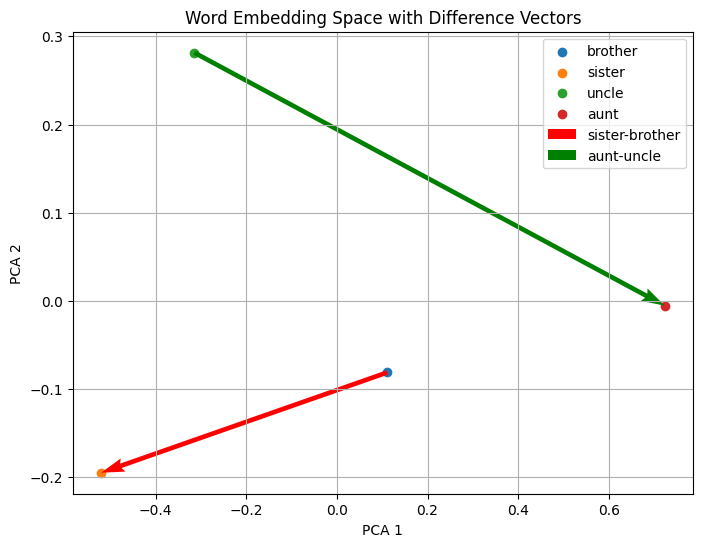

In [31]:
words = ['brother', 'sister', 'uncle', 'aunt']
embeddings = np.array([get_word_embedding(word, model, word_index).flatten() for word in words])

# apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# compute difference vectors
diff_vectors = np.array([reduced_embeddings[1] - reduced_embeddings[0],  # sister - brother
                         reduced_embeddings[3] - reduced_embeddings[2]]) # aunt - uncle


plt.figure(figsize=(8, 6))

# plot original word embeddings
for i, word in enumerate(words):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=word)

# plot difference vectors
plt.quiver(*reduced_embeddings[0], *diff_vectors[0], color='r', scale=1, scale_units='xy', angles='xy', label='sister-brother')
plt.quiver(*reduced_embeddings[2], *diff_vectors[1], color='g', scale=1, scale_units='xy', angles='xy', label='aunt-uncle')

plt.legend()
plt.title('Word Embedding Space with Difference Vectors')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()
